In [1]:
# 1. Importing the required libraries and modules
import torchvision 
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from PIL import Image 
from torch import optim
import cv2
import glob
import numpy as np
import pandas as pd 
from glob import glob 
import matplotlib.pyplot as plt
from torchsummary import summary

# Setting the device to CUDA if available, otherwise using CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# 2. Define directories for the training and test datasets
train_data_dir = '/kaggle/input/cat-and-dog/training_set/training_set'
test_data_dir = '/kaggle/input/cat-and-dog/test_set/test_set'

# 3. Create a class for loading data from the specified folders
class CatsAndDogsDataset(Dataset):
    def __init__(self, folder):
        cat_images = glob(folder + '/cats/*.jpg')
        dog_images = glob(folder + '/dogs/*.jpg')
        self.file_paths = cat_images + dog_images

        # Shuffle the file paths
        from random import shuffle, seed
        seed(10)
        shuffle(self.file_paths)

        # Assign binary labels (dog=1, cat=0) based on file names
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, ix):
        file_path = self.file_paths[ix]
        target = self.targets[ix]

        # Read and preprocess the image
        image = cv2.imread(file_path)[:, :, ::-1]
        image = cv2.resize(image, (224, 224))
        image_tensor = torch.tensor(image / 255).permute(2, 0, 1).to(device).float()

        # Return the preprocessed image and its label
        return image_tensor, torch.tensor([target]).float().to(device)


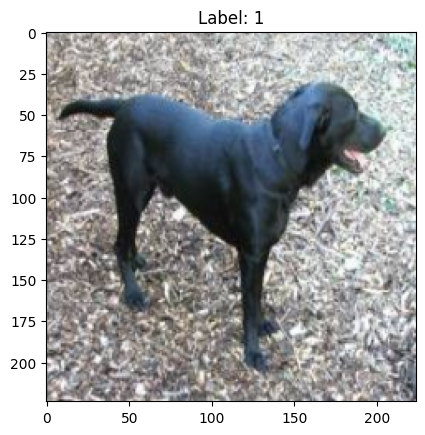

In [3]:
# 4. Visualize a randomly selected image from the dataset
dataset = CatsAndDogsDataset(train_data_dir)
image, label = dataset[200]

# Display the image using Matplotlib
plt.imshow(image.permute(1, 2, 0).cpu())  # Permute the image for Matplotlib compatibility
plt.title(f"Label: {int(label)}")
plt.show()

In [4]:
# 5. Define a model, loss function, and optimizer

def conv_layer(ni, no, kernel_size, stride=1):
    """
    Define a convolutional layer block.
    
    Args:
        ni (int): Number of input channels.
        no (int): Number of output channels.
        kernel_size (int): Size of the convolutional kernel.
        stride (int, optional): Stride for the convolution operation. Defaults to 1.
    
    Returns:
        nn.Sequential: Sequential container for the convolutional layer block.
    """
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

def get_model():
    """
    Create a convolutional neural network model.

    Returns:
        tuple: A tuple containing the model, loss function, and optimizer.
    """
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid(),
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    return model, loss_fn, optimizer

In [5]:
# summarize the model using the summary method 
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [6]:
# 6. Create the get_data function, which creates an object of the cats_dogs class and creates a DataLoader with a batch_size of 32 for both the training and validation folders
def get_data():
    # Instantiate the cats_dogs class for training data
    train_dataset = CatsAndDogsDataset(train_data_dir)
    
    # Create a DataLoader for training data with a batch size of 32, enabling shuffling and dropping the last incomplete batch
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    
    # Instantiate the cats_dogs class for validation data
    val_dataset = CatsAndDogsDataset(test_data_dir)
    
    # Create a DataLoader for validation data with a batch size of 32, enabling shuffling and dropping the last incomplete batch
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
    
    # Return the training and validation DataLoaders
    return train_dataloader, val_dataloader


# 7. Define the function that will train the model on a batch of data
def train_batch(input_data, target, model, optimizer, loss_function):
    # Set the model to training mode
    model.train()

    # Forward pass
    predictions = model(input_data)

    # Compute the batch loss
    batch_loss = loss_function(predictions, target)

    # Backward pass and optimization
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Return the batch loss as a Python float
    return batch_loss.item()


# 8. Define the functions for calculating accuracy and validation loss
## Define the accuracy function
@torch.inference_mode()
def calculate_accuracy(input_data, target, model):
    # Get model predictions
    predictions = model(input_data)

    # Determine correctness of predictions
    is_correct = (predictions > 0.5) == target

    # Convert to a list of boolean values and return
    return is_correct.cpu().numpy().tolist()

## Define the validation loss calculation function
@torch.inference_mode()
def calculate_validation_loss(input_data, target, model, loss_function):
    # Get model predictions
    predictions = model(input_data)

    # Calculate the validation loss
    validation_loss = loss_function(predictions, target)

    # Return the validation loss as a Python float
    return validation_loss.item()


In [7]:
# 9. Train the model for 5 epochs and check the accuracy of the test data at the end of each epoch
def train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer, num_epochs=5):
    train_losses, train_accuracies = [], []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch: {epoch}")

        # Training
        model.train()
        train_epoch_losses, train_epoch_accuracies = [], []
        for batch in trn_dl:
            x, y = batch
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)

            is_correct = calculate_accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)

        train_epoch_loss = torch.tensor(train_epoch_losses).mean().item()
        train_epoch_accuracy = torch.tensor(train_epoch_accuracies).float().mean().item()

        # Validation
        model.eval()
        val_epoch_accuracies = []
        for batch in val_dl:
            x, y = batch
            val_is_correct = calculate_accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)

        val_epoch_accuracy = torch.tensor(val_epoch_accuracies).float().mean().item()

        # Print and store results
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_accuracies.append(val_epoch_accuracy)

    return train_losses, train_accuracies, val_accuracies

In [8]:
## Train the model over increasing epochs 8K data points
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies, val_accuracies = train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer)


Epoch: 1
Train Loss: 0.6725, Train Accuracy: 0.6712, Validation Accuracy: 0.6820
Epoch: 2
Train Loss: 0.5291, Train Accuracy: 0.7595, Validation Accuracy: 0.7867
Epoch: 3
Train Loss: 0.4133, Train Accuracy: 0.8404, Validation Accuracy: 0.7887
Epoch: 4
Train Loss: 0.3307, Train Accuracy: 0.8857, Validation Accuracy: 0.8775
Epoch: 5
Train Loss: 0.2489, Train Accuracy: 0.9304, Validation Accuracy: 0.8874


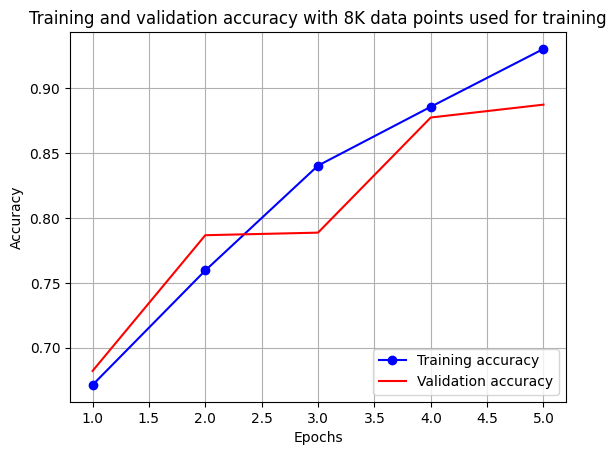

In [9]:
# 10. Plot the variation of the training and validation accuracies over increasing epochs
epochs = np.arange(1, 6)  

plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')

plt.title('Training and validation accuracy with 8K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')  
plt.grid(True)  
#plt.ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
plt.show()

`Note` that the classification accuracy at the end of 5 epochs is ~86%.

---
# Impact on the number of images used for training

### 1000 images for Training 

In [10]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, folder):
        cat_images = glob(folder + '/cats/*.jpg')
        dog_images = glob(folder + '/dogs/*.jpg')
        self.file_paths = cat_images[:500] + dog_images[:500]

        # Shuffle the file paths
        from random import shuffle, seed
        seed(10)
        shuffle(self.file_paths)

        # Assign binary labels (dog=1, cat=0) based on file names
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, ix):
        file_path = self.file_paths[ix]
        target = self.targets[ix]

        # Read and preprocess the image
        image = cv2.imread(file_path)[:, :, ::-1]
        image = cv2.resize(image, (224, 224))
        image_tensor = torch.tensor(image / 255).permute(2, 0, 1).to(device).float()

        # Return the preprocessed image and its label
        return image_tensor, torch.tensor([target]).float().to(device)

In [11]:
## Train the model over increasing epochs 1K data points
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies, val_accuracies_1k = train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer)


Epoch: 1
Train Loss: 0.8439, Train Accuracy: 0.6411, Validation Accuracy: 0.5393
Epoch: 2
Train Loss: 0.6167, Train Accuracy: 0.6935, Validation Accuracy: 0.6290
Epoch: 3
Train Loss: 0.5531, Train Accuracy: 0.7661, Validation Accuracy: 0.6683
Epoch: 4
Train Loss: 0.4905, Train Accuracy: 0.8054, Validation Accuracy: 0.6613
Epoch: 5
Train Loss: 0.4285, Train Accuracy: 0.8569, Validation Accuracy: 0.6129


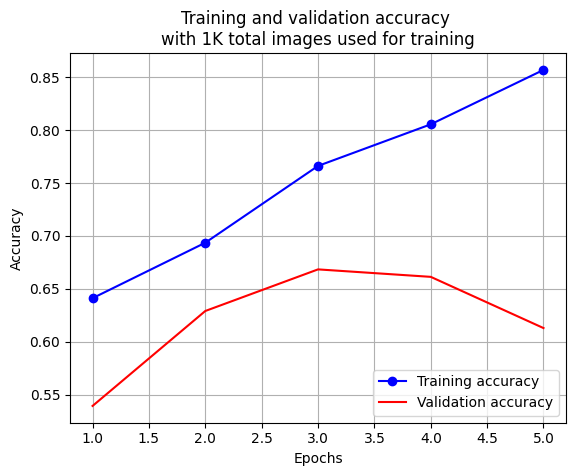

In [12]:
epochs = np.arange(1, 6)  

plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies_1k, 'r-', label='Validation accuracy')

plt.title('Training and validation accuracy \nwith 1K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')  
plt.grid(True)  
#plt.ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
plt.show()

### 2000 Images for Training

In [13]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, folder):
        cat_images = glob(folder + '/cats/*.jpg')
        dog_images = glob(folder + '/dogs/*.jpg')
        self.file_paths = cat_images[:1000] + dog_images[:1000]

        # Shuffle the file paths
        from random import shuffle, seed
        seed(10)
        shuffle(self.file_paths)

        # Assign binary labels (dog=1, cat=0) based on file names
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, ix):
        file_path = self.file_paths[ix]
        target = self.targets[ix]

        # Read and preprocess the image
        image = cv2.imread(file_path)[:, :, ::-1]
        image = cv2.resize(image, (224, 224))
        image_tensor = torch.tensor(image / 255).permute(2, 0, 1).to(device).float()

        # Return the preprocessed image and its label
        return image_tensor, torch.tensor([target]).float().to(device)

In [14]:
## Train the model over increasing epochs 1K data points
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies, val_accuracies_2k = train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer)

Epoch: 1
Train Loss: 0.8016, Train Accuracy: 0.6245, Validation Accuracy: 0.6124
Epoch: 2
Train Loss: 0.6073, Train Accuracy: 0.6804, Validation Accuracy: 0.6694
Epoch: 3
Train Loss: 0.5691, Train Accuracy: 0.7344, Validation Accuracy: 0.6930
Epoch: 4
Train Loss: 0.5417, Train Accuracy: 0.7581, Validation Accuracy: 0.6799
Epoch: 5
Train Loss: 0.4960, Train Accuracy: 0.7757, Validation Accuracy: 0.6830


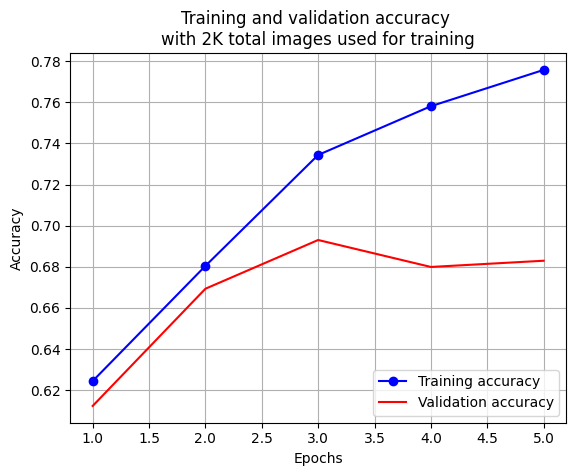

In [15]:
# 10. Plot the variation of the training and validation accuracies over increasing epochs
epochs = np.arange(1, 6)  
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies_2k, 'r-', label='Validation accuracy')

plt.title('Training and validation accuracy \nwith 2K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')  
plt.grid(True)  
#plt.ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
plt.show()

### 4000 Images for Training

In [16]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, folder):
        cat_images = glob(folder + '/cats/*.jpg')
        dog_images = glob(folder + '/dogs/*.jpg')
        self.file_paths = cat_images[:2000] + dog_images[:2000]

        # Shuffle the file paths
        from random import shuffle, seed
        seed(10)
        shuffle(self.file_paths)

        # Assign binary labels (dog=1, cat=0) based on file names
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, ix):
        file_path = self.file_paths[ix]
        target = self.targets[ix]

        # Read and preprocess the image
        image = cv2.imread(file_path)[:, :, ::-1]
        image = cv2.resize(image, (224, 224))
        image_tensor = torch.tensor(image / 255).permute(2, 0, 1).to(device).float()

        # Return the preprocessed image and its label
        return image_tensor, torch.tensor([target]).float().to(device)

In [17]:
## Train the model over increasing epochs 1K data points
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies, val_accuracies_4k = train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer)

Epoch: 1
Train Loss: 0.7351, Train Accuracy: 0.6265, Validation Accuracy: 0.6622
Epoch: 2
Train Loss: 0.5889, Train Accuracy: 0.7215, Validation Accuracy: 0.6974
Epoch: 3
Train Loss: 0.5159, Train Accuracy: 0.7710, Validation Accuracy: 0.7391
Epoch: 4
Train Loss: 0.4442, Train Accuracy: 0.8242, Validation Accuracy: 0.7619
Epoch: 5
Train Loss: 0.3857, Train Accuracy: 0.8570, Validation Accuracy: 0.7951


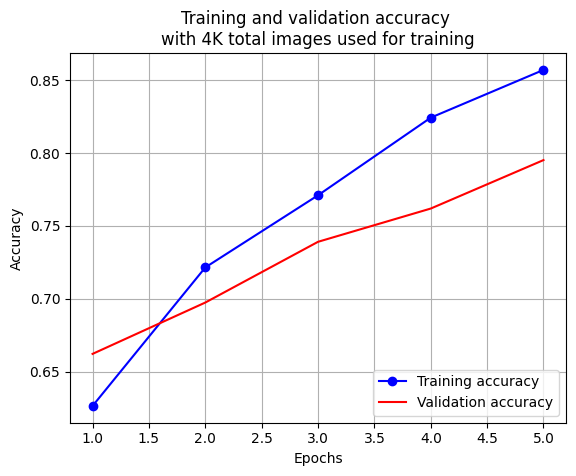

In [18]:
# 10. Plot the variation of the training and validation accuracies over increasing epochs
epochs = np.arange(1, 6)  

plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies_4k, 'r-', label='Validation accuracy')

plt.title('Training and validation accuracy \nwith 4K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')  
plt.grid(True)  
#plt.ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
plt.show()

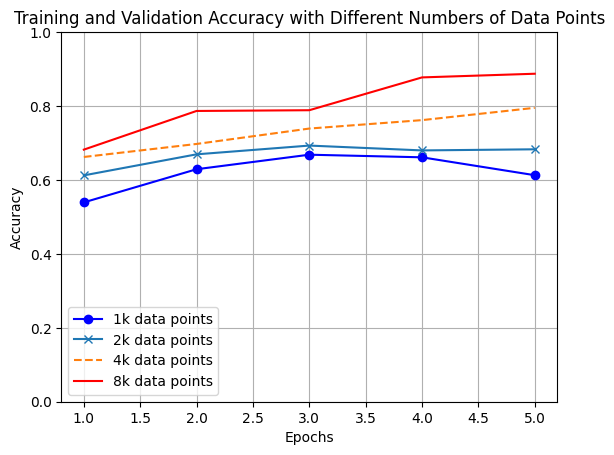

In [19]:
# 10. Plot the variation of the training and validation accuracies over increasing epochs
epochs = np.arange(1, 6)
plt.plot(epochs, val_accuracies_1k, 'bo-', label='1k data points')
plt.plot(epochs, val_accuracies_2k, 'x-', label='2k data points')
plt.plot(epochs, val_accuracies_4k, '--', label='4k data points', markersize=20)
plt.plot(epochs, val_accuracies, 'r-', label='8k data points')

plt.title('Training and Validation Accuracy with Different Numbers of Data Points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  

# Place legend in the best position to avoid overlapping
plt.legend(loc='best')

# Turn off the grid
plt.grid(True)
plt.show()
